In [12]:
#!pip install segysak

In [13]:
import tqdm.auto
import numpy as np
import time
from scipy.interpolate import CubicSpline
import pandas as pd
import collections
import segysak
from segysak import segy
from segysak.segy import segy_loader, segy_header_scrape, well_known_byte_locs
import cv2
import matplotlib.pyplot as plt
from numba import jit
%matplotlib inline

In [14]:
class Semblance:

    path = "D:/germany/seismic.segy"

    def __init__(self, header=None):
        if header!=None:
            self.header = header

    def text_header(self):
        return segy.get_segy_texthead(Semblance.path)

    def bin_scrap(self):
        return segy.segy_bin_scrape(Semblance.path)

    def header_scan(self):
        return segy.segy_header_scan(Semblance.path)

    def header_scrap(self):
        return segy_header_scrape(Semblance.path)

    def get_header_values(self):
        return Semblance.header_scrap(self)[self.header].to_numpy()

    def CountFrequency(self):
        return collections.Counter(Semblance.get_header_values(self))

    def loader(self):
        return segy_loader(Semblance.path, vert_domain='TWT')

    @staticmethod
    def shot(gather):
        return np.array(gather.data[np.arange(0,gather.data.shape[0])]).T

    @staticmethod
    def shot_plotter(shot, offset_traces, trace_number, times):
        fig = plt.figure(figsize=(3, 5))
        cutoff = 0.05

        ax = plt.subplot(121)

        #ax.set_title('SHOT 2',fontsize=30)
        #ax.set_xlabel('trace number',fontsize=20)
        #ax.set_ylabel('time (sec) ',fontsize=20)
        ax.imshow(shot[:,120:240], extent=[trace_number[239], trace_number[119], times[-1], 0],
          aspect='auto', cmap='Greys', vmin=-cutoff, vmax=cutoff)
        fig.savefig('shot2.png', dpi=100)

        ax = plt.subplot(122)
        ax.set_title('SHOT 2',fontsize=30)
        ax.set_xlabel('offsets (m) ',fontsize=20)
        ax.set_ylabel('time (sec) ',fontsize=20)
        ax.imshow(shot[:,120:240], extent=[offset_traces[240], offset_traces[119], times[-1], 0],
          aspect='auto', cmap='Greys', vmin=-cutoff, vmax=cutoff)

        plt.show()

    @staticmethod
    def cdp_trace(traces, cdp_traces, cdp_no):
        return traces[cdp_traces==cdp_no]

    @staticmethod
    def cdp_offsets(offset_traces, cdp_traces, cdp_no):
        return offset_traces[cdp_traces==cdp_no]

    @staticmethod
    def cdp_short(shot, trace):
        return shot[:,trace]

    @staticmethod
    def cdp_plotter(cdp, cdp_traces, cdp_offsets, cdp_no, times):
        fig = plt.figure(figsize=(3, 5))
        cutoff = 0.05

        ax = plt.subplot(121)

        #ax.set_title(f'CMP {cdp_no}',fontsize=30)
        #ax.set_xlabel('trace number',fontsize=20)
        #ax.set_ylabel('time (sec)' ,fontsize=20)
        ax.imshow(cdp, extent=[cdp_traces[0], cdp_traces[-1], times[-1], 0],
                  aspect='auto', cmap='Greys', vmin=-cutoff, vmax=cutoff)
        fig.savefig('cdp450.png', dpi=100)
        ax = plt.subplot(122)
        ax.set_title(f'CMP {cdp_no}',fontsize=30)
        ax.set_xlabel('offsets (m) ',fontsize=20)
        ax.set_ylabel('time (sec) ',fontsize=20)
        ax.imshow(cdp, extent=[cdp_offsets[0], cdp_offsets[-1], times[-1], 0],
                  aspect='auto', cmap='Greys', vmin=-cutoff, vmax=cutoff)
        plt.show()

    @staticmethod
    def build_line_segments(fig, ax):
        def line_builder(event):
            if event.inaxes != ax:
                return
            xs.append(event.xdata)
            ys.append(event.ydata)
            line.set_data(xs, ys)
            fig.canvas.draw()

        line, = ax.plot([], [], c='r')  # empty line
        xs, ys = [], []

        fig.canvas.mpl_connect('button_press_event', line_builder)

        return xs, ys

    @staticmethod
    def cdp_mute_pick(cdp, cdp_offsets, cdp_no, times):
        fig = plt.figure(figsize=(20, 10))
        cutoff = 0.5
        ax = plt.subplot(121)
        ax.set_title('cdp 450',fontsize=30)
        ax.set_xlabel('offset ',fontsize=20)
        ax.set_ylabel('Time (sec) ',fontsize=20)
        aspect = 'auto'
        ax.imshow(cdp, extent=[cdp_offsets[0], cdp_offsets[-1], times[-1], 0],
                          aspect='auto', cmap='Greys', vmin=-cutoff, vmax=cutoff)
        X, Y = Semblance.build_line_segments(fig, ax)
        plt.show()

        return X, Y

    @staticmethod
    def cdp_mute(cdp, cdp_offsets, off_mute, t_mute, sample_rate):

        mute = np.interp(abs(cdp_offsets), abs(np.array(off_mute)), np.array(t_mute))
        l = np.round(mute/sample_rate).astype('i')
        cdp_mute = cdp.copy()
        N = np.arange(0, cdp_mute.shape[0])

        for i, j in enumerate(cdp_mute.T):
            j[N <= l[i]] = 0.0

        return mute, cdp_mute

    @staticmethod
    def cdp_mute_plotter(cdp, mute, cdp_mute, cdp_offsets, cdp_no, times):

        fig = plt.figure(figsize=(3, 5))
        cutoff = 0.5

        ax = plt.subplot(121)

        #ax.set_title(f'CMP {cdp_no}',fontsize=20)
        #ax.set_xlabel('offset ',fontsize=20)
        #ax.set_ylabel('time (sec)' ,fontsize=20)
        ax.imshow(cdp, extent=[cdp_offsets[0], cdp_offsets[-1], times[-1], 0],
                  aspect='auto', cmap='Greys', vmin=-cutoff, vmax=cutoff)

        fig.savefig('cdp150.png', dpi=100)
        ax.plot(cdp_offsets, mute, color='r')


        ax = plt.subplot(122)
        ax.set_title('cdp_muted 450',fontsize=20)
        ax.set_xlabel('offset ',fontsize=20)
        ax.set_ylabel('Time (sec) ',fontsize=20)
        aspect = 'auto'
        ax.imshow(cdp_mute, extent=[cdp_offsets[0], cdp_offsets[-1], times[-1], 0],
                          aspect='auto', cmap='Greys', vmin=-cutoff, vmax=cutoff)
        plt.show()

    @staticmethod
    def velocity(min_vel, max_vel, interval):
        return np.arange(min_vel, max_vel, interval)

    @staticmethod
    #moveout equation
    @jit(nopython=True)
    def reflection_time(time, offset, velocity):
        t = np.sqrt(time**2 + offset**2/velocity**2)
        return t

    @staticmethod
    def interpolate_amplitude(cmp, trajectory, sample_rate):

      amp = np.zeros(len(trajectory))
      n_samples, n_traces = cmp.shape
      dt = sample_rate

      time = trajectory/dt

      traj = time.astype('i')

      mask = (traj < n_samples - 1 ) & ( traj >= 0 )

      t_before = traj
      t_after = t_before + 1
      ntr = np.arange(n_traces)

      amp0 = cmp[t_before[mask], ntr[mask]]
      amp1 = cmp[t_after[mask], ntr[mask]]

      interp = (amp0 * (time - t_after)[mask])/ ((t_before - t_after)[mask]) + (amp1 * (time - t_before)[mask]) / ((t_after - t_before)[mask])

      return interp

    @staticmethod
    def semblance_IA(cmp, times, offsets, velocities, window, sample_rate):

        n_samples, n_traces = cmp.shape
        semb = np.zeros((len(times), len(velocities)))

        for i, time in enumerate(times):

            for q, velocity in enumerate(velocities):

                trajectory = Semblance.reflection_time(time, offsets, velocity)

                amp = Semblance.interpolate_amplitude(cmp, trajectory, sample_rate)

                l = np.round(trajectory / sample_rate)

                l1 = np.arange(-window//2, 0)
                l2 = np.arange(0, window//2)

                win1 = np.clip(l[:, None] + l1, 0, n_samples - 2).astype('i')
                win2 = np.clip(l[:, None] + l2, 0, n_samples - 2).astype('i')

                n_tr = np.arange(0, n_traces)
                amp1 = cmp[win1.T, n_tr]
                amp2 = cmp[win2.T, n_tr]

                num = (amp1.sum(axis=1)**2).sum() + amp.sum()**2 + (amp2.sum(axis=1)**2).sum()
                den = (amp1**2).sum(axis=1).sum() + (amp**2).sum() + (amp2**2).sum(axis=1).sum()

                semb[i,q] = num/(n_traces*(den+1e-10))

        return semb

    @staticmethod
    @jit(nopython=True)
    def cubic_spline_interpolate_amplitude(cdp, trajectory, sample_rate):

        amp = np.zeros(len(trajectory))
        dt = sample_rate

        for i, trace in enumerate(cdp.T):

            time = trajectory[i]
            before = int(np.floor(time/dt))
            N = trace.size
            # Use the 4 samples around time to interpolate
            samples = np.arange(before - 1, before + 3)

            if before < 0 or before+3 >= N:
                amplitude = 0.0

            else:
                times = dt*samples
                amps = trace[samples]

                n = len(times)
                h = [times[i + 1] - times[i] for i in range(n - 1)]

                # Initialize coefficients arrays
                a = amps.copy()
                b = [0.0] * n
                d = [0.0] * n
                c = [0.0] * n
                l = [0.0] * n
                u = [0.0] * n
                z = [0.0] * n

                for i in range(1, n - 1):
                    alpha = (3.0 / h[i]) * (a[i + 1] - a[i]) - (3.0 / h[i - 1]) * (a[i] - a[i - 1])
                    l[i] = 2.0 * (times[i + 1] - times[i - 1]) - h[i - 1] * u[i - 1]
                    u[i] = h[i] / l[i]
                    z[i] = (alpha - h[i - 1] * z[i - 1]) / l[i]

                for j in range(n - 2, -1, -1):
                    c[j] = z[j] - u[j] * c[j + 1]
                    b[j] = (a[j + 1] - a[j]) / h[j] - h[j] * (c[j + 1] + 2.0 * c[j]) / 3.0
                    d[j] = (c[j + 1] - c[j]) / (3.0 * h[j])

                dtt = time - times[1]
                amplitude = a[1] + b[1] * dtt + c[1] * dtt**2 + d[1] * dtt**3

            amp[i] = amplitude

        return amp

    @staticmethod
    def semblance_CS(cmp, times, offsets, velocities, window, sample_rate):

        n_samples, n_traces = cmp.shape
        semb = np.zeros((len(times), len(velocities)))

        for i, time in enumerate(times):

            for q, velocity in enumerate(velocities):

                trajectory = Semblance.reflection_time(time, offsets, velocity)

                amp = Semblance.cubic_spline_interpolate_amplitude(cmp, trajectory, sample_rate)

                l = trajectory // sample_rate

                l1 = np.arange(-window//2, 0)
                l2 = np.arange(1, (window//2)+1)

                win1 = np.clip(l[:, None] + l1, 0, n_samples - 1).astype('i')
                win2 = np.clip(l[:, None] + l2, 0, n_samples - 1).astype('i')

                n_tr = np.arange(0, n_traces)
                amp1 = cmp[win1.T, n_tr]
                amp2 = cmp[win2.T, n_tr]

                num = (amp1.sum(axis=1)**2).sum() + amp.sum()**2 + (amp2.sum(axis=1)**2).sum()
                den = (amp1**2).sum(axis=1).sum() + (amp**2).sum() + (amp2**2).sum(axis=1).sum()

                semb[i,q] = num/(n_traces*(den+1e-12))

        return semb

    @staticmethod
    def weights(amps, offsets):

        phi = offsets
        N = len(offsets)

        A = (np.sum(phi)*np.sum(amps*phi) - np.sum(phi**2)*np.sum(amps))/  \
        (np.sum(phi)**2 - N*np.sum(phi**2))

        B = (np.sum(phi)*np.sum(amps) - N*np.sum(phi*amps))/ \
             (np.sum(phi)**2 - N*np.sum(phi**2))

        return A + B*phi

    @staticmethod
    def semblance_IA_AB(cmp, times, offsets, velocities, window, sample_rate):

        n_samples, n_traces = cmp.shape
        semb = np.zeros((len(times), len(velocities)))
        vect_weight = np.vectorize(Semblance.weights, signature='(m),(m)->(n)')

        for i,time in enumerate(times):

            for q, velocity in enumerate(velocities):

                trajectory = Semblance.reflection_time(time, offsets, velocity)

                amp = Semblance.interpolate_amplitude(cmp, trajectory, sample_rate)

                l = trajectory // sample_rate

                l1 = np.arange(-window//2, 0)
                l2 = np.arange(1, (window//2)+1)

                win1 = np.clip(l[:, None] + l1, 0, n_samples - 1).astype('i')
                win2 = np.clip(l[:, None] + l2, 0, n_samples - 1).astype('i')

                n_tr = np.arange(0, n_traces)
                amp1 = cmp[win1.T, n_tr]
                amp2 = cmp[win2.T, n_tr]

                w_amp = vect_weight(amp, offsets)
                w_amp1 = vect_weight(amp1, offsets)
                w_amp2 = vect_weight(amp2, offsets)

                num = ((amp1*w_amp1).sum(axis=1)**2).sum() + (amp*w_amp).sum()**2 + ((amp2*w_amp2).sum(axis=1)**2).sum()

                den = ((amp1**2).sum(axis=1)*(w_amp1**2).sum(axis=1)).sum() + ((amp**2).sum())*((w_amp**2).sum()) + \
                                                                          ((amp2**2).sum(axis=1)*(w_amp2**2).sum(axis=1)).sum()

                semb[i,q] = num/(den+1e-12)

        return semb

    @staticmethod
    def semblance_CS_AB(cmp, times, offsets, velocities, window, sample_rate):

        n_samples, n_traces = cmp.shape
        semb = np.zeros((len(times), len(velocities)))
        vect_weight = np.vectorize(Semblance.weights, signature='(m),(m)->(n)')

        for i,time in enumerate(times):

            for q, velocity in enumerate(velocities):

                trajectory = Semblance.reflection_time(time, offsets, velocity)

                amp = Semblance.cubic_spline_interpolate_amplitude(cmp, trajectory, sample_rate)

                l = trajectory // sample_rate

                l1 = np.arange(-window//2, 0)
                l2 = np.arange(1, (window//2)+1)

                win1 = np.clip(l[:, None] + l1, 0, n_samples - 1).astype('i')
                win2 = np.clip(l[:, None] + l2, 0, n_samples - 1).astype('i')

                n_tr = np.arange(0, n_traces)
                amp1 = cmp[win1.T, n_tr]
                amp2 = cmp[win2.T, n_tr]

                w_amp = vect_weight(amp, offsets)
                w_amp1 = vect_weight(amp1, offsets)
                w_amp2 = vect_weight(amp2, offsets)

                num = ((amp1*w_amp1).sum(axis=1)**2).sum() + (amp*w_amp).sum()**2 + ((amp2*w_amp2).sum(axis=1)**2).sum()

                den = ((amp1**2).sum(axis=1)*(w_amp1**2).sum(axis=1)).sum() + ((amp**2).sum())*((w_amp**2).sum()) + \
                                                                          ((amp2**2).sum(axis=1)*(w_amp2**2).sum(axis=1)).sum()

                semb[i,q] = num/(den+1e-12)

        return semb

    @staticmethod
    def semblance_plotter(semblance, semblance_mute, velocity, times, cdp_no, window):

        fig = plt.figure(figsize=(10, 7))

        ax = plt.subplot(121)
        #ax.set_title(f'Semblance for cdp={cdp_no}, window={window}', fontsize=13)
        #ax.set_xlabel('Velocity (m/sec) ',fontsize=15)
        #ax.set_ylabel('Time (sec) ',fontsize=15)
        aspect = 'auto'
        clip=0.9
        ii = ax.imshow(semblance, extent=[velocity[0], velocity[-1], times[-1], 0],
          aspect=aspect, cmap='jet', vmin=0, vmax=clip*np.max(semblance))
        #plt.colorbar(ii, label="semblance",shrink=0.5, ax=ax)
        ax.axis("off")
        fig.savefig('sf.png', dpi=100)
        ax = plt.subplot(122)
        ax.set_title(f'Semblance for cdp_mute={cdp_no}, window={window}', fontsize=13)
        ax.set_xlabel('Velocity (m/sec) ',fontsize=15)
        ax.set_ylabel('Time (sec) ',fontsize=15)
        aspect = 'auto'
        ii = ax.imshow(semblance_mute, extent=[velocity[0], velocity[-1], times[-1], 0],
          aspect=aspect, cmap='jet', vmin=0, vmax=clip*np.max(semblance_mute))
        #plt.colorbar(ii, label="semblance",shrink=0.5, ax=ax)
        ax.axis("off")
        fig.savefig('sw.png', dpi=100)

        plt.show()

In [15]:
Semblance.path

'D:/germany/seismic.segy'

In [16]:
text_header = Semblance().text_header()

In [17]:
text_header = Semblance()
text_header.text_header()

Text HeaderC 1 CLIENT                        COMPANY                       CREW NO
C 2 LINE            AREA                        MAP ID
C 3 REEL NO           DAY-START OF REEL     YEAR      OBSERVER
C 4 INSTRUMENT: MFG            MODEL            SERIAL NO
C 5 DATA TRACES/RECORD        AUXILIARY TRACES/RECORD         CDP FOLD
C 6 SAMPLE INTERNAL         SAMPLES/TRACE       BITS/IN      BYTES/SAMPLE
C 7 RECORDING FORMAT        FORMAT THIS REEL        MEASUREMENT SYSTEM
C 8 SAMPLE CODE: FLOATING PT     FIXED PT     FIXED PT-GAIN     CORRELATED
C 9 GAIN  TYPE: FIXED     BINARY     FLOATING POINT     OTHER
C10 FILTERS: ALIAS     HZ  NOTCH     HZ  BAND    -     HZ  SLOPE    -    DB/OCT
C11 SOURCE: TYPE            NUMBER/POINT        POINT INTERVAL
C12     PATTERN:                           LENGTH        WIDTH
C13 SWEEP: START     HZ  END     HZ  LENGTH      MS  CHANNEL NO     TYPE
C14 TAPER: START LENGTH       MS  END LENGTH       MS  TYPE
C15 SPREAD: OFFSET        MAX DISTANCE        GROUP INTERVAL
C16 GEOPHONES: PER GROUP     SPACING     FREQUENCY     MFG          MODEL
C17     PATTERN:                           LENGTH        WIDTH
C18 TRACES SORTED BY: RECORD     CDP     OTHER
C19 AMPLITUDE RECOVEY: NONE      SPHERICAL DIV       AGC    OTHER
C20 MAP PROJECTION                      ZONE ID       COORDINATE UNITS
C21 PROCESSING:
C22 PROCESSING:
C23
C24
C25
C26
C27
C28
C29
C30
C31
C32
C33
C34
C35
C36
C37
C38
C39
C40 END EBCDIC

In [18]:
biin = Semblance()
biin.bin_scrap()

{'JobID': 9999,
 'LineNumber': 9999,
 'ReelNumber': 1,
 'Traces': 120,
 'AuxTraces': 0,
 'Interval': 4000,
 'IntervalOriginal': 4000,
 'Samples': 1500,
 'SamplesOriginal': 1500,
 'Format': 1,
 'EnsembleFold': 0,
 'SortingCode': 1,
 'VerticalSum': 1,
 'SweepFrequencyStart': 0,
 'SweepFrequencyEnd': 0,
 'SweepLength': 0,
 'Sweep': 0,
 'SweepChannel': 0,
 'SweepTaperStart': 0,
 'SweepTaperEnd': 0,
 'Taper': 0,
 'CorrelatedTraces': 2,
 'BinaryGainRecovery': 1,
 'AmplitudeRecovery': 4,
 'MeasurementSystem': 1,
 'ImpulseSignalPolarity': 1,
 'VibratoryPolarity': 0,
 'ExtTraces': 0,
 'ExtAuxTraces': 0,
 'ExtSamples': 0,
 'ExtSamplesOriginal': 0,
 'ExtEnsembleFold': 0,
 'SEGYRevision': 0,
 'SEGYRevisionMinor': 0,
 'TraceFlag': 0,
 'ExtendedHeaders': 0}

In [19]:
header_scan = Semblance()
header_scan.header_scan()

  0%|          | 0.00/1.00k [00:00<?, ? traces/s]

,byte_loc,count,mean,std,min,25%,50%,75%,max
TRACE_SEQUENCE_LINE,1,1000.0,500.50,288.819436,1.0,250.75,500.5,750.25,1000.0
TRACE_SEQUENCE_FILE,5,1000.0,500.50,288.819436,1.0,250.75,500.5,750.25,1000.0
FieldRecord,9,1000.0,6.68,2.413177,3.0,5.00,7.0,9.00,11.0
TraceNumber,13,1000.0,58.90,34.927209,1.0,28.00,58.0,89.00,120.0
EnergySourcePoint,17,1000.0,104.68,2.413177,101.0,103.00,105.0,107.00,109.0
...,...,...,...,...,...,...,...,...,...
SourceEnergyDirectionMantissa,219,1000.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0
SourceEnergyDirectionExponent,223,1000.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementMantissa,225,1000.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementExponent,229,1000.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0


In [20]:
header_scrap = Semblance()
header_scrap.header_scrap()

  0%|          | 0.00/120k [00:00<?, ? traces/s]

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,TransductionConstantPower,TransductionUnit,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit
0,1,1,3,1,101,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,2,3,2,101,2,2,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,3,3,3,101,3,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,4,3,4,101,4,4,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,5,3,5,101,5,5,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120115,120116,120116,1003,116,1112,2138,116,1,0,1,...,0,0,0,0,0,0,0,0,0,0
120116,120117,120117,1003,117,1112,2139,117,1,0,1,...,0,0,0,0,0,0,0,0,0,0
120117,120118,120118,1003,118,1112,2140,118,1,0,1,...,0,0,0,0,0,0,0,0,0,0
120118,120119,120119,1003,119,1112,2141,119,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
header_scrap.header_scrap().columns

  0%|          | 0.00/120k [00:00<?, ? traces/s]

Index(['TRACE_SEQUENCE_LINE', 'TRACE_SEQUENCE_FILE', 'FieldRecord',
       'TraceNumber', 'EnergySourcePoint', 'CDP', 'CDP_TRACE',
       'TraceIdentificationCode', 'NSummedTraces', 'NStackedTraces', 'DataUse',
       'offset', 'ReceiverGroupElevation', 'SourceSurfaceElevation',
       'SourceDepth', 'ReceiverDatumElevation', 'SourceDatumElevation',
       'SourceWaterDepth', 'GroupWaterDepth', 'ElevationScalar',
       'SourceGroupScalar', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'CoordinateUnits', 'WeatheringVelocity', 'SubWeatheringVelocity',
       'SourceUpholeTime', 'GroupUpholeTime', 'SourceStaticCorrection',
       'GroupStaticCorrection', 'TotalStaticApplied', 'LagTimeA', 'LagTimeB',
       'DelayRecordingTime', 'MuteTimeStart', 'MuteTimeEND',
       'TRACE_SAMPLE_COUNT', 'TRACE_SAMPLE_INTERVAL', 'GainType',
       'InstrumentGainConstant', 'InstrumentInitialGain', 'Correlated',
       'SweepFrequencyStart', 'SweepFrequencyEnd', 'SweepLength', 'SweepType',
       'Swee

In [22]:
trace_number = Semblance("TRACE_SEQUENCE_LINE")
trace_number.header

'TRACE_SEQUENCE_LINE'

In [23]:
traces = trace_number.get_header_values()

  0%|          | 0.00/120k [00:00<?, ? traces/s]

In [24]:
offset_traces = Semblance("offset")
offset_traces.header

'offset'

In [25]:
off_traces = offset_traces.get_header_values()

  0%|          | 0.00/120k [00:00<?, ? traces/s]

In [26]:
cdp_traces = Semblance("CDP")
cdp_traces.header

'CDP'

In [27]:
cdp_tr = cdp_traces.get_header_values()

  0%|          | 0.00/120k [00:00<?, ? traces/s]

In [28]:
cdp_tr

array([   1,    2,    3, ..., 2140, 2141, 2142], dtype=uint16)

In [29]:
cdp = np.unique(cdp_traces.get_header_values())
offsets = np.unique(offset_traces.get_header_values())

  0%|          | 0.00/120k [00:00<?, ? traces/s]

  0%|          | 0.00/120k [00:00<?, ? traces/s]

In [30]:
cdp, offsets

(array([   1,    2,    3, ..., 2140, 2141, 2142], dtype=uint16),
 array([-3237, -3212, -3187, -3162, -3137, -3112, -3087, -3062, -3037,
        -3012, -2987, -2962, -2937, -2912, -2887, -2862, -2837, -2812,
        -2787, -2762, -2737, -2712, -2687, -2662, -2637, -2612, -2587,
        -2562, -2537, -2512, -2487, -2462, -2437, -2412, -2387, -2362,
        -2337, -2312, -2287, -2262, -2237, -2212, -2187, -2162, -2137,
        -2112, -2087, -2062, -2037, -2012, -1987, -1962, -1937, -1912,
        -1887, -1862, -1837, -1812, -1787, -1762, -1737, -1712, -1687,
        -1662, -1637, -1612, -1587, -1562, -1537, -1512, -1487, -1462,
        -1437, -1412, -1387, -1362, -1337, -1312, -1287, -1262, -1237,
        -1212, -1187, -1162, -1137, -1112, -1087, -1062, -1037, -1012,
         -987,  -962,  -937,  -912,  -887,  -862,  -837,  -812,  -787,
         -762,  -737,  -712,  -687,  -662,  -637,  -612,  -587,  -562,
         -537,  -512,  -487,  -462,  -437,  -412,  -387,  -362,  -337,
         -31

In [31]:
cdp_freq = Semblance("CDP")
freq = cdp_freq.CountFrequency()

  0%|          | 0.00/120k [00:00<?, ? traces/s]

In [32]:
fold =  np.array([freq[i+1] for i in range(len(freq))])
fold

array([1, 1, 2, ..., 2, 1, 1])

In [33]:
gather = Semblance().loader()

  0%|          | 0.00/120k [00:00<?, ? traces/s]

                     byte_loc     count          mean           std     min  \
TRACE_SEQUENCE_LINE         1  120120.0  60060.500000  34675.801505     1.0   
TRACE_SEQUENCE_FILE         5  120120.0  60060.500000  34675.801505     1.0   
FieldRecord                 9  120120.0    503.000000    288.964868     3.0   
TraceNumber                13  120120.0     60.500000     34.639958     1.0   
EnergySourcePoint          17  120120.0    608.011988    291.880762   101.0   
CDP                        21  120120.0   1074.523976    584.788376     1.0   
CDP_TRACE                  25  120120.0     60.500000     34.639958     1.0   
offset                     37  120120.0  -1749.500000    865.998938 -3237.0   
SourceX                    73  120120.0  15912.299700   7297.019059  3237.0   
GroupX                     81  120120.0  14162.799700   7348.227086     0.0   

                          25%      50%       75%       max  unique  
TRACE_SEQUENCE_LINE  30030.75  60060.5  90090.25  120120.0  1

Converting SEGY:   0%|          | 0.00/120k [00:00<?, ? traces/s]

In [34]:
shot = gather.data.data.T

In [35]:
shot.shape

(1500, 120120)

In [36]:
shot

array([[ 0.02718735, -0.55144596, -0.8152704 , ...,  0.41021824,
         0.588233  ,  0.5701065 ],
       [-0.28261852, -0.05700493,  0.08163643, ..., -0.26972103,
         0.81987953, -0.12695026],
       [ 0.29055214,  0.81935215,  0.19066429, ..., -0.4683094 ,
         0.2450962 , -0.91893864],
       ...,
       [-0.32296944,  0.09628773,  0.825614  , ..., -0.5066166 ,
         0.05440044,  1.199316  ],
       [-0.62256145, -0.69131947,  0.37403393, ...,  0.62419987,
         1.3795891 ,  0.70394325],
       [-0.74348164, -0.75914955,  0.09736061, ...,  1.4178886 ,
         1.026226  ,  0.11193657]], dtype=float32)

In [37]:
#shot = Semblance.shot(gather)

In [38]:
times = np.array(gather.data.twt)*10**-3  #two way zero-offset travel time
dt = biin.bin_scrap()['Interval']*10**-6   #sampling interval
n_samples = biin.bin_scrap()['Samples']     # no. of samples

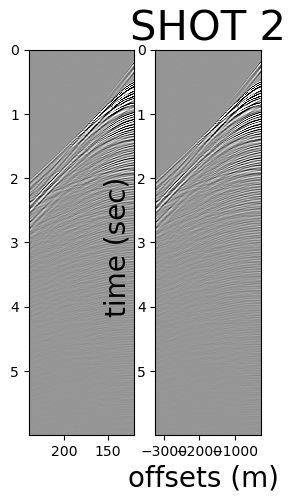

In [39]:
Semblance.shot_plotter(shot/np.max(shot), off_traces, traces, times=times)

In [40]:
sh_n = shot/np.max(shot)

In [41]:
tr_450 = Semblance.cdp_trace(traces, cdp_tr, cdp_no=450)

In [42]:
tr_450

array([19320, 19438, 19556, 19674, 19792, 19910, 20028, 20146, 20264,
       20382, 20500, 20618, 20736, 20854, 20972, 21090, 21208, 21326,
       21444, 21562, 21680, 21798, 21916, 22034, 22152, 22270, 22388,
       22506, 22624, 22742, 22860, 22978, 23096, 23214, 23332, 23450,
       23568, 23686, 23804, 23922, 24040, 24158, 24276, 24394, 24512,
       24630, 24748, 24866, 24984, 25102, 25220, 25338, 25456, 25574,
       25692, 25810, 25928, 26046, 26164, 26282], dtype=uint32)

In [43]:
off_450 = Semblance.cdp_offsets(off_traces, cdp_tr, cdp_no=450)
off_450

array([ -262,  -312,  -362,  -412,  -462,  -512,  -562,  -612,  -662,
        -712,  -762,  -812,  -862,  -912,  -962, -1012, -1062, -1112,
       -1162, -1212, -1262, -1312, -1362, -1412, -1462, -1512, -1562,
       -1612, -1662, -1712, -1762, -1812, -1862, -1912, -1962, -2012,
       -2062, -2112, -2162, -2212, -2262, -2312, -2362, -2412, -2462,
       -2512, -2562, -2612, -2662, -2712, -2762, -2812, -2862, -2912,
       -2962, -3012, -3062, -3112, -3162, -3212], dtype=int64)

In [44]:
cdp450 = Semblance.cdp_short(shot, tr_450)

In [45]:
cdp450

array([[ 0.590333  ,  0.3002138 , -0.18918705, ...,  0.23583698,
        -0.39700603,  0.18612957],
       [ 0.17236423, -0.0774498 , -0.19428635, ...,  0.30181694,
        -0.43197536,  0.13204098],
       [ 0.01982212, -0.5933542 ,  0.14841652, ...,  0.0100832 ,
         0.08058929,  0.12439156],
       ...,
       [-0.09115028,  0.76809597,  0.5681467 , ...,  0.33618736,
         1.1191235 , -0.08787727],
       [-0.1563921 ,  0.4252844 ,  1.404623  , ...,  0.4013443 ,
         0.80076694,  0.6405802 ],
       [-0.25592232, -0.2728958 ,  0.48001766, ...,  0.02680779,
        -0.03726673,  0.1673193 ]], dtype=float32)

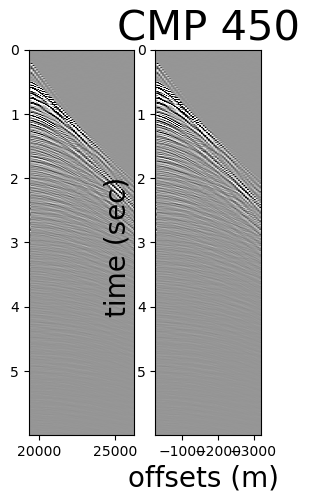

In [46]:
Semblance.cdp_plotter(cdp450/np.max(cdp450), tr_450, off_450, cdp_no= 450, times=times)

In [47]:
#off_mute, t_mute = Semblance.cdp_mute_pick(cdp450, off_450, 450, times)

In [48]:
#off_mute, t_mute

In [49]:
#mute, cdp450_mute = Semblance.cdp_mute(cdp450, off_450, off_mute, t_mute, sample_rate=dt)

In [50]:
#Semblance.cdp_mute_plotter(cdp450, mute, cdp450_mute, off_450, 450, times)

In [51]:
velocity = np.arange(1200, 3610, 10)

In [52]:
semb = [] # store semblance 2142cdps interval - 50

In [53]:
t1 = time.time()
sw = Semblance.semblance_IA(cdp450, times, off_450, velocity, window=15, sample_rate=dt)
t2 = time.time()
t2 - t1

54.34345984458923

In [54]:
sw

array([[0.00525374, 0.00494246, 0.00192896, ..., 0.03162614, 0.03228362,
        0.04055085],
       [0.00334485, 0.0049429 , 0.00192797, ..., 0.03151824, 0.0321367 ,
        0.03980435],
       [0.00334527, 0.00494419, 0.00192501, ..., 0.03119862, 0.03376263,
        0.03932207],
       ...,
       [0.01381586, 0.01393931, 0.01394008, ..., 0.03520525, 0.03540154,
        0.03534014],
       [0.01040349, 0.01093368, 0.01093367, ..., 0.0266125 , 0.02716921,
        0.02717049],
       [0.0106982 , 0.01102898, 0.01102898, ..., 0.02154001, 0.02165409,
        0.0227334 ]])

In [55]:
semb.append(sw/np.max(sw))

In [56]:
len(semb)

1

In [57]:
cdp450_mute = cdp450

In [58]:
t1 = time.time()
sw_mute = Semblance.semblance_IA(cdp450_mute, times, off_450, velocity, window=15, sample_rate=dt)
t2 = time.time()
t2 - t1

47.39331865310669

In [59]:
sw.max(), sw.min()

(0.48194096357158767, 7.271719465680604e-05)

In [60]:
swn = (sw - sw.min())/(sw.max() + sw.min())

In [61]:
swn.max(), swn.min()

(0.99969827746573, 0.0)

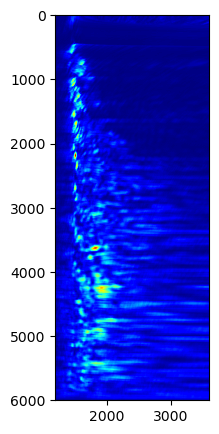

In [62]:
plt.figure(figsize=(3, 5))
plt.imshow(sw, extent=[1200, 3600, 6000, 0], cmap='jet')


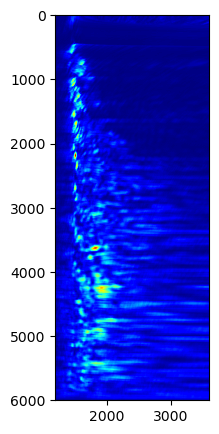

In [63]:
plt.figure(figsize=(3, 5))
plt.imshow(swn, extent=[1200, 3600, 6000, 0], cmap='jet')

In [64]:
fsfdhgf

NameError: name 'fsfdhgf' is not defined

In [ ]:
Semblance.semblance_plotter(sw, sw, velocity, times, cdp_no=450, window=15 )

In [65]:
def semblancew(d, x, t, t0, vrms, nsmooth=5):
    """Semblance Stack

    Parameters
    ----------
    d : np.ndarray
        Data (nt x nx)
    x : np.ndarray
        Spatial axis
    t : np.ndarray
        Time axis
    t0 : np.ndarray
        Zero-offset time axis
    vrms : np.ndarray
        Root-mean-square velocity axis
    nsmooth : int, optional
        Length of smoothing filter

    Returns
    -------
    ss : np.ndarray
        Semblance stack (nt0 x nvrms)

    """
    # identify sampling and dimensions
    dt = t[1]-t[0]
    nx = x.size
    nt = t.size
    nvrms = vrms.size
    nt0 = t0.size

    # compute semblance
    ix = np.arange(nx)
    num = np.zeros((nt0, nvrms))
    den = np.zeros((nt0, nvrms))
    nn = np.zeros((nt0, nvrms))
    for it0, t0_ in enumerate(t0):
        for ivrms, vrms_ in enumerate(vrms):
            tevent = np.sqrt(t0_ ** 2 + x ** 2 / vrms_ ** 2)
            tevent = (tevent - t[0]) / dt
            itevent = tevent.astype(int)
            dtevent = tevent - itevent
            mask = (itevent < nt - 1) & (itevent >= 0)
            dss = d[itevent[mask], ix[mask]] * (1 - dtevent[mask]) + d[itevent[mask] + 1, ix[mask]] * dtevent[mask]
            num[it0, ivrms] = np.sum(dss)**2
            den[it0, ivrms] = np.sum(dss**2)
            nn[it0, ivrms] = len(dss)
    ss = num / (nn * den + 1e-10)

    # smooth along time axis
    ss = filt.filtfilt(np.ones(nsmooth) / nsmooth, 1, ss.T).T
    return ss

In [66]:
def interpolate_amplitude(cmp, trajectory, sample_rate):

    amp = np.zeros(len(trajectory))
    n_samples, n_traces = cmp.shape
    dt = sample_rate

    time = trajectory/dt

    traj = time.astype('i')

    mask = (traj < n_samples - 1 ) & ( traj >= 0 )

    t_before = traj
    t_after = t_before + 1
    ntr = np.arange(n_traces)

    amp0 = cmp[t_before[mask], ntr[mask]]
    amp1 = cmp[t_after[mask], ntr[mask]]

    interp = (amp0 * (time - t_after)[mask])/ ((t_before - t_after)[mask]) + (amp1 * (time - t_before)[mask]) / ((t_after - t_before)[mask])

    return interp

In [67]:
def linear_interpolation(cmp, trajectory, sample_rate):


    n_samples, n_traces = cmp.shape

    time = trajectory
    t_lower = (time/sample_rate).astype('i')
    t_upper = (t_lower + 1).astype('i')
    del_t = time - t_lower

    idx = (t_lower < n_samples - 1) & (t_lower >= 0)
    ntr = np.arange(n_traces)

    amp_lower = cmp[t_lower[idx], ntr[idx]]
    amp_upper = cmp[t_upper[idx], ntr[idx]]

    # Calculate the interpolation weight
    #weight_upper = (x - x_lower) / (x_upper - x_lower)
    #weight_lower = 1.0 - weight_upper
    m = (y_upper - y_lower) / (x_upper[idx] - x_lower[idx])


    # Perform linear interpolation
    #interpolated_value = y_lower * weight_lower[idx] + y_upper * weight_upper[idx]
    interpolated_value = y_lower + m*(x - x_lower)[idx]

    return interpolated_value


In [68]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as filt

t0axis = times.copy()
t1 = time.time()
ss = semblancew(cdp450, off_450, times, t0axis, velocity, nsmooth=30)
t2 = time.time()
t2-t1


14.952550888061523

In [69]:
def semblance_IA(cmp, times, offsets, velocities, window, sample_rate):

        n_samples, n_traces = cmp.shape
        semb = np.zeros((len(times), len(velocities)))
        l1 = np.arange(-window//2, 0)
        l2 = np.arange(0, window//2)
        ntr = np.arange(60)

        for n, time in enumerate(times):

            for q, velocity in enumerate(velocities):

                trajectory = Semblance.reflection_time(time, offsets, velocity)

                amp = interpolate_amplitude(cmp, trajectory, sample_rate)

                l = np.round(trajectory / sample_rate).astype('i')

                win1 = (l[:, None] + l1).T.astype('i')
                win2 = (l[:, None] + l2).T.astype('i')

                win11 = np.logical_and(win1 >= 0, win1 < n_samples)
                win22 = np.logical_and(win2 >= 0, win2 < n_samples)

                amp1 = [cmp[win1[i, win11[i]], ntr[win11[i]]] for i in range(len(win1))]
                amp2 = [cmp[win2[i, win22[i]], ntr[win22[i]]] for i in range(len(win2))]


                num1 = sum([(amp1[i].sum())**2 for i in range(len(amp1))])
                den1 = sum([((amp1[i]**2).sum())*len(amp1[i]) for i in range(len(amp1))])
                num2 = sum([(amp2[i].sum())**2 for i in range(len(amp2))])
                den2 = sum([((amp2[i]**2).sum())*len(amp2[i]) for i in range(len(amp2))])

                num = np.sum(amp)**2 + num1 + num2
                den =  np.sum(amp**2)*len(amp) + den1 + den2

                semb[n,q] = num/(den)# + 1e-10)

        #semb = filt.filtfilt(np.ones(window) / window, 1, semb.T).T

        return semb


In [78]:
def semblance_IA(cmp, times, offsets, velocities, window, sample_rate):

        n_samples, n_traces = cmp.shape
        semb = np.zeros((len(times), len(velocities)))
        l1 = np.arange(-window//2, 0)
        l2 = np.arange(0, window//2)
        ntr = np.arange(60)

        for n, time in enumerate(times):

            for q, velocity in enumerate(velocities):

                trajectory = Semblance.reflection_time(time, offsets, velocity)

                amp = interpolate_amplitude(cmp, trajectory, sample_rate)

                l = (trajectory / sample_rate).astype('i')

                win1 = (l[:, None] + l1).T.astype('i')
                win2 = (l[:, None] + l2).T.astype('i')

                win11 = np.logical_and(win1 >= 0, win1 < n_samples)
                win22 = np.logical_and(win2 >= 0, win2 < n_samples)

                amp1 = [cmp[win1[i, w], ntr[w]] for i, w in enumerate(win11)]
                amp2 = [cmp[win2[i, w], ntr[w]] for i, w in enumerate(win22)]


                num1 = sum([(a.sum())**2 for a in amp1])
                den1 = sum([((a**2).sum())*len(a) for a in amp1])
                num2 = sum([(a.sum())**2 for a in amp2])
                den2 = sum([((a**2).sum())*len(a) for a in amp2])

                num = np.sum(amp)**2 + num1 + num2
                den =  np.sum(amp**2)*len(amp) + den1 + den2

                semb[n,q] = num/(den)# + 1e-10)


        return semb

In [76]:
import joblib
from joblib import Parallel, delayed

def semblance_IA(cmp, times, offsets, velocities, window, sample_rate):

        n_samples, n_traces = cmp.shape
        #semb = np.zeros((len(times), len(velocities)))
        l1 = np.arange(-window//2, 0)
        l2 = np.arange(0, window//2)
        ntr = np.arange(60)

        def semb(time, velocity):

          trajectory = Semblance.reflection_time(time, offsets, velocity)

          amp = interpolate_amplitude(cmp, trajectory, sample_rate)

          l = np.round(trajectory / sample_rate).astype('i')

          win1 = (l[:, None] + l1).T.astype('i')
          win2 = (l[:, None] + l2).T.astype('i')

          win11 = np.logical_and(win1 >= 0, win1 < n_samples)
          win22 = np.logical_and(win2 >= 0, win2 < n_samples)

          amp1 = [cmp[win1[i, win11[i]], ntr[win11[i]]] for i in range(len(win1))]
          amp2 = [cmp[win2[i, win22[i]], ntr[win22[i]]] for i in range(len(win2))]


          num1 = sum([(amp1[i].sum())**2 for i in range(len(amp1))])
          den1 = sum([((amp1[i]**2).sum())*len(amp1[i]) for i in range(len(amp1))])
          num2 = sum([(amp2[i].sum())**2 for i in range(len(amp2))])
          den2 = sum([((amp2[i]**2).sum())*len(amp2[i]) for i in range(len(amp2))])

          num = np.sum(amp)**2 + num1 + num2
          den =  np.sum(amp**2)*len(amp) + den1 + den2

          return num/den

        results = Parallel(n_jobs=8)(delayed(semb)(time, velocity) for time in times for velocity in velocities)

        ss = np.array(results).reshape(len(times), len(velocities))

        return ss


In [79]:
t1 = time.time()
sw = semblance_IA(cdp450, times, off_450, velocity, window=30, sample_rate=dt)
t2 = time.time()
t2-t1

184.2291784286499

In [ ]:
sw.tofile('data.bin')

In [ ]:
sw = (sw - sw.min())/(sw.max() - sw.min())

In [ ]:
window = 30
sw1  = filt.filtfilt(np.ones(window) / window, 1, sw.T).T
sw1.max()


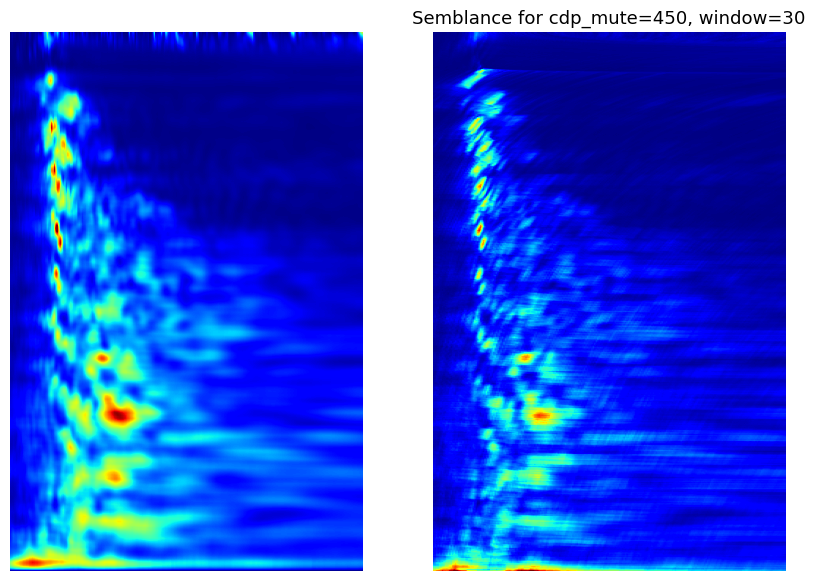

In [73]:
Semblance.semblance_plotter(ss, sw, velocity, times, cdp_no=450, window=30 )

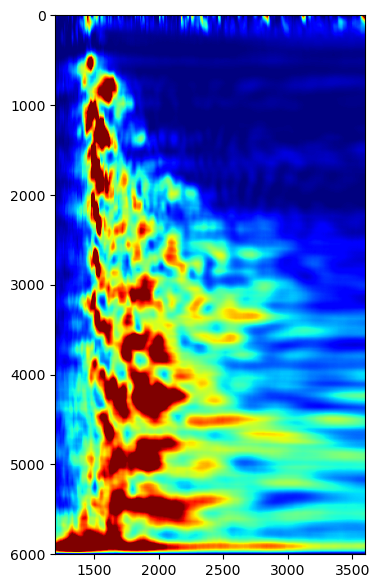

In [84]:
plt.figure(figsize=(4, 7))
vmin, vmax = np.percentile(ss, [5,95])
plt.imshow(ss, extent=[1200, 3600, 6000, 0], cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
import cv2

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import cv2
import copy


def cal_contour_area(binary_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = 0
    for contr in contours:
        area += cv2.contourArea(contr)
    return area


def autopicker(power_matrix,
               velocity,
               frequency,
               threshold_power=0.6,
               DBSCAN_eps=8,
               DBSCAN_samples=20,

               ):
    # vv, ff = np.meshgrid(velocity, frequency)
    filtered_mat = np.where(power_matrix>0.6, power_matrix, 0)

    # threshold filering
    thresh_above_ids = np.argwhere(power_matrix>threshold_power)
    vfmat = []
    for id in thresh_above_ids:
        vfmat.append([velocity[id[0]], frequency[id[1]]])
    vfmat = np.asarray(vfmat)
    # clustering
    dbscan = DBSCAN(eps=DBSCAN_eps,
                    min_samples=DBSCAN_samples,
                    algorithm="brute")
    clabels = dbscan.fit_predict(vfmat)

    # save clusters to dictionaries
    clusters = dict()
    for l in np.unique(clabels):
        clusters.update({
            l : []
        })
    clusters_in_power_spec = copy.deepcopy(clusters)

    plt.figure()
    plt.scatter(vfmat[:, 1].flatten(), vfmat[:,0].flatten(), c=clabels, cmap="viridis", label=f" Clusters")
    plt.colorbar()
    plt.title(f"kmeans clustering clusters")
    plt.xlabel("frequency")
    plt.ylabel("velocity")
    plt.show()
    for i,j in enumerate(clabels):
        #print(i,j)
        clusters[j].append(vfmat[i])
        clusters_in_power_spec[j].append(thresh_above_ids[i])

    cluster_vf = []
    cluster_po_ids = []
    for k in clusters_in_power_spec.keys():
        cluster_vf.append(np.asarray(clusters[k]))
        cluster_po_ids.append(np.asarray(clusters_in_power_spec[k]))

    # print(cluster_vf)
    # print(cluster_po_ids)

    # distinguising modes and noise
    modes = []

    for l, [powrsids, vfmat] in enumerate(zip(cluster_po_ids, cluster_vf)):
        cluster_matrix = np.zeros_like(filtered_mat, dtype="float")
        for pid in powrsids:
            cluster_matrix[*pid] = filtered_mat[*pid]

        cpts_id = np.argmax(cluster_matrix, axis=0)
        print(cpts_id)

        non_zero_ids = np.where(cpts_id!=0)[0]

        p = np.poly1d(np.polyfit(frequency[non_zero_ids], velocity[cpts_id[non_zero_ids]], 20))
        interpv = p(frequency[non_zero_ids])
        diff = np.linalg.norm(velocity[cpts_id[non_zero_ids]] - interpv)
        # if diff < 100:
        bin_img = np.where(cluster_matrix > 0, 255, 0).astype(np.uint8)
        kernel = np.ones((5, 5), np.uint8)
        bin_img = cv2.erode(bin_img, kernel, iterations=1)
        bin_img = cv2.dilate(bin_img, kernel, iterations=1)
        plt.figure()
        plt.imshow(bin_img)
        plt.show()
        area = cal_contour_area(bin_img)

        if area > 50:
            plt.figure(figsize=(10,5))
            plt.imshow(cluster_matrix, aspect="auto", cmap="turbo", extent=(2, 80, 500, 20))
            plt.scatter(frequency[non_zero_ids], interpv, color="r", s=5)
            plt.scatter(frequency[non_zero_ids],  velocity[cpts_id[non_zero_ids]], color="w", s=5)
            plt.title(f"{diff}   {area}")
            plt.gca().invert_yaxis()
            plt.show()
            modes.append([interpv, frequency[non_zero_ids]])

    plt.figure(figsize=(10,5))
    cm = plt.imshow(power_matrix, cmap="jet", aspect="auto", extent=(2,80,500,20))
    plt.colorbar(cm)
    for m in zip(modes):
        plt.plot(m[0][1], m[0][0], "w.")

    plt.gca().invert_yaxis()
    plt.show()
    return modes


if __name__ == "__main__":
    freq_mat = np.load("freq_mat.npy")
    power_mat = np.load("data_power_2.npy")
    vx = np.linspace(20, 500, 100)
    fy = freq_mat[0]

    modes = autopicker(power_matrix=power_mat,
               velocity=vvelocity,
               frequency=times)

In [ ]:
power_matrix = sw
threshold_power=0.2
DBSCAN_eps=8
DBSCAN_samples=20
frequency = times
velocity = velocity

In [ ]:
filtered_mat = np.where(power_matrix>0.2, power_matrix, 0)
filtered_mat.max()

In [ ]:
filtered_mat.shape

In [ ]:
thresh_above_ids = np.argwhere(power_matrix>threshold_power)
vfmat = []
for id in thresh_above_ids:
    vfmat.append([velocity[id[1]], frequency[id[0]]])
vfmat = np.asarray(vfmat)
# clustering
dbscan = DBSCAN(eps=DBSCAN_eps,
                min_samples=DBSCAN_samples,
                algorithm="brute")
clabels = dbscan.fit_predict(vfmat)

In [ ]:
thresh_above_ids[80:90]

In [ ]:
vfmat[0]

In [ ]:
#clabels, set(clabels)
import copy

In [ ]:
# save clusters to dictionaries
clusters = dict()
for l in np.unique(clabels):
    clusters.update({
        l : []
    })
clusters_in_power_spec = copy.deepcopy(clusters)

plt.figure()
plt.scatter(vfmat[:, 0].flatten(), vfmat[:, 1].flatten(), c=clabels, cmap="viridis", label=f" Clusters")
plt.colorbar()
plt.title(f"kmeans clustering clusters")
plt.xlabel("velocity")
plt.ylabel("time")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
power_matrix = sw.T
# vv, ff = np.meshgrid(velocity, frequency)
filtered_mat = np.where(power_matrix>0.2, power_matrix, 0)

# threshold filering
thresh_above_ids = np.argwhere(power_matrix>threshold_power)
vfmat = []
for id in thresh_above_ids:
    vfmat.append([velocity[id[0]], frequency[id[1]]])
vfmat = np.asarray(vfmat)
# clustering
dbscan = DBSCAN(eps=DBSCAN_eps,
                min_samples=DBSCAN_samples,
                algorithm="brute")
clabels = dbscan.fit_predict(vfmat)

# save clusters to dictionaries
clusters = dict()
for l in np.unique(clabels):
    clusters.update({
        l : []
    })
clusters_in_power_spec = copy.deepcopy(clusters)

plt.figure()
plt.scatter(vfmat[:, 1].flatten(), vfmat[:,0].flatten(), c=clabels, cmap="viridis", label=f" Clusters")
plt.imshow(sw, aspect="auto", extent=())
plt.colorbar()
plt.title(f"kmeans clustering clusters")
plt.xlabel("Time")
plt.ylabel("velocity")
plt.show()

In [ ]:
for i,j in enumerate(clabels):
    #print(i,j)
    clusters[j].append(vfmat[i])
    clusters_in_power_spec[j].append(thresh_above_ids[i])

cluster_vf = []
cluster_po_ids = []
for k in clusters_in_power_spec.keys():
    cluster_vf.append(np.asarray(clusters[k]))
    cluster_po_ids.append(np.asarray(clusters_in_power_spec[k]))

#print(cluster_vf)
#print(cluster_po_ids)

In [ ]:

def cal_contour_area(binary_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = 0
    for contr in contours:
        area += cv2.contourArea(contr)
    return area

In [ ]:
# distinguising modes and noise
modes = []

for l, [powrsids, vfmat] in enumerate(zip(cluster_po_ids, cluster_vf)):
  cluster_matrix = np.zeros_like(filtered_mat, dtype="float")
  for pid in powrsids:
    cluster_matrix[pid] = filtered_mat[pid]

    cpts_id = np.argmax(cluster_matrix, axis=0)
    #print(cpts_id)

    non_zero_ids = np.where(cpts_id!=0)[0]
    arr = np.arange(0,241)

    p = np.poly1d(np.polyfit(frequency[non_zero_ids], velocity[arr[non_zero_ids]], 10))
    interpv = p(frequency[non_zero_ids])
    diff = np.linalg.norm(velocity[arr[non_zero_ids]] - interpv)
    # if diff < 100:
    bin_img = np.where(cluster_matrix > 0, 255, 0).astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)
    bin_img = cv2.erode(bin_img, kernel, iterations=1)
    bin_img = cv2.dilate(bin_img, kernel, iterations=1)
    plt.figure(figsize=(10,5))
    plt.imshow(bin_img)
    plt.show()
    area = cal_contour_area(bin_img)

    if area > 20:
        plt.figure(figsize=(10,5))
        plt.imshow(cluster_matrix, aspect="auto", cmap="turbo", extent=(2, 80, 500, 20))
        plt.scatter(frequency[non_zero_ids], interpv, color="r", s=5)
        plt.scatter(frequency[non_zero_ids],  velocity[arr[non_zero_ids]], color="w", s=5)
        plt.title(f"{diff}   {area}")
        plt.gca().invert_yaxis()
        plt.show()
        modes.append([interpv, frequency[non_zero_ids]])


In [ ]:
plt.figure(figsize=(10,5))
cm = plt.imshow(power_matrix, cmap="jet", aspect="auto", extent=(2,80,500,20))
plt.colorbar(cm)
for m in zip(modes):
    plt.plot(m[0][1], m[0][0], "w.")

plt.gca().invert_yaxis()
plt.show()

In [ ]:
cpts_id

In [ ]:
len(velocity)

In [ ]:
len(np.arange(0,241))

In [ ]:
cpts_id = np.argmax(cluster_matrix, axis=0)
cpts_id.shape

In [ ]:
non_zero_ids

In [ ]:
cluster_matrix.shape, filtered_mat.shape

In [85]:
ss = sw.copy()

In [86]:
# New
ssn = (ss - ss.min())/(ss.max() - ss.min())

In [87]:

ssn

array([[0.00921055, 0.01028707, 0.00689777, ..., 0.06105486, 0.06380091,
        0.0626439 ],
       [0.0089048 , 0.01028752, 0.0068966 , ..., 0.0609132 , 0.06361013,
        0.06242224],
       [0.00890519, 0.01028887, 0.00689309, ..., 0.06555782, 0.05862561,
        0.05124993],
       ...,
       [0.57572517, 0.60921153, 0.6633404 , ..., 0.20779451, 0.20780123,
        0.21534077],
       [0.65690902, 0.69434304, 0.7821467 , ..., 0.23106088, 0.24238248,
        0.2379299 ],
       [0.7775039 , 0.76020513, 0.86508397, ..., 0.23805562, 0.25174191,
        0.24845768]])

In [88]:
threshold = 0.4
ssnt = np.where(ssn>threshold, ssn, 0)

In [89]:
ssnt.min(), ssnt.max()

(0.0, 1.0)

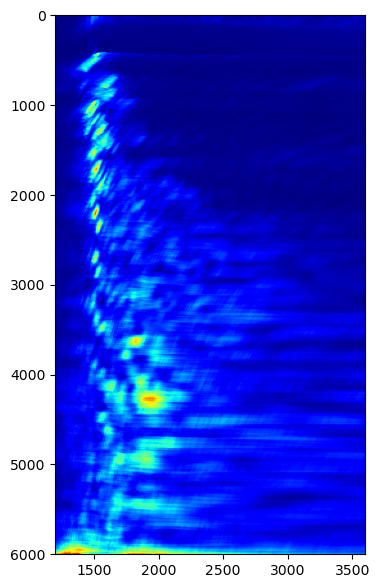

In [94]:
plt.figure(figsize=(4, 7))
plt.imshow(ssn, extent=[1200, 3600, 6000, 0], cmap='jet', aspect='auto')
plt.show()

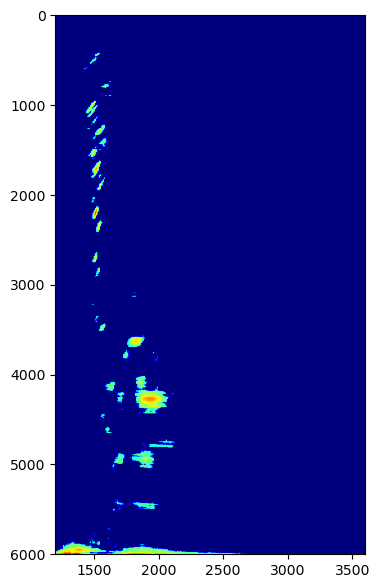

In [95]:
plt.figure(figsize=(4, 7))
plt.imshow(ssnt, extent=[1200, 3600, 6000, 0], cmap='jet', aspect='auto')
plt.show()

In [96]:
swnt_ind = np.argwhere(ssn>threshold)

In [97]:
swnt_ind.shape

(6652, 2)

In [98]:
times = np.linspace(0, 6, 1500)
times

array([0.00000000e+00, 4.00266845e-03, 8.00533689e-03, ...,
       5.99199466e+00, 5.99599733e+00, 6.00000000e+00])

In [99]:
vtmat = []
for indx in swnt_ind:
  vtmat.append(np.array([times[indx[0]], velocity[indx[1]]]))
vtmat = np.asarray(vtmat)

In [100]:
vtmat.shape

(6652, 2)

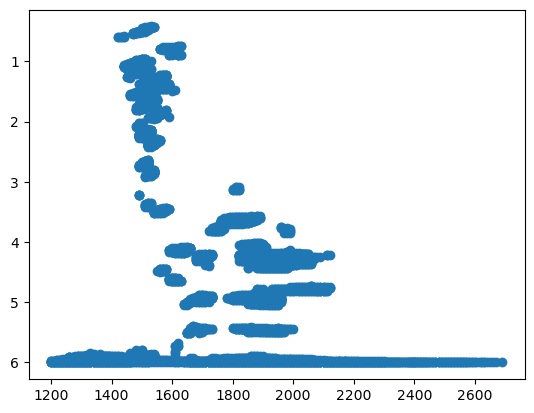

In [101]:
plt.scatter(vtmat[:,1], vtmat[:, 0])
plt.gca().invert_yaxis()

In [102]:
idx_remove = np.argwhere((vtmat[:, 1] < 1450))# | (vtmat[:, 1] > 3400))
idx_remove.shape

(614, 1)

In [103]:
vtmat = np.delete(vtmat, idx_remove, axis=0)
vtmat.shape

(6038, 2)

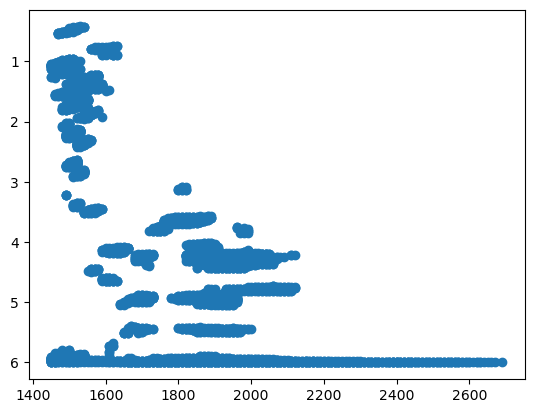

In [104]:
plt.scatter(vtmat[:,1], vtmat[:, 0])
plt.gca().invert_yaxis()

In [105]:
k = 12
vx = np.linspace(0, 240, k).astype('i')
ty = np.linspace(0, 1499, k).astype('i')
centr = np.array([[times[ty[i]], velocity[vx[i]]] for i in range(len(vx))])
centr

array([[0.00000000e+00, 1.20000000e+03],
       [5.44362909e-01, 1.41000000e+03],
       [1.08872582e+00, 1.63000000e+03],
       [1.63308873e+00, 1.85000000e+03],
       [2.18145430e+00, 2.07000000e+03],
       [2.72581721e+00, 2.29000000e+03],
       [3.27018012e+00, 2.50000000e+03],
       [3.81454303e+00, 2.72000000e+03],
       [4.36290861e+00, 2.94000000e+03],
       [4.90727151e+00, 3.16000000e+03],
       [5.45163442e+00, 3.38000000e+03],
       [6.00000000e+00, 3.60000000e+03]])

In [109]:
vtmat.shape

(6038, 2)

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate sample data
X = vtmat

# Perform K-means clustering
init = ['random', 'k-means++']
algo = ["lloyd", "elkan", "auto", "full"]

# initialization
kmeans = KMeans(n_clusters=12, n_init=1, init=centr, algorithm=algo[0])

kmeans.fit(X)
labels = kmeans.predict(X)
centers = kmeans.cluster_centers_


# Plot the clustered data points and centroids
plt.scatter(X[:, 1], X[:, 0], c=labels, cmap='viridis', s=50, alpha=0.5)
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=100, alpha=0.8)
plt.xlabel('velocity')
plt.ylabel('time')
plt.title('K-means Clustering')
plt.gca().invert_yaxis()
#plt.legend()
plt.show()


AttributeError: 'NoneType' object has no attribute 'split'

In [129]:
kmeans = KMeans(n_clusters=12, n_init=1, init=centr, algorithm=algo[0])

kmeans.fit(X)

AttributeError: 'NoneType' object has no attribute 'split'

In [123]:
conda install -c conda-forge openblas


error: incomplete escape \U at position 28

In [ ]:

centers

In [ ]:
def distance(X, centers):
  dis = np.array([np.linalg.norm(x - cent)**2 for cent in centers for x in X])
  return dis

In [ ]:
def incremental_clustering(vtmat, K, max_iterations):
    K = K
    previous_residual = float('inf')
    while True:
      vx = np.linspace(0, 240, K).astype('i')
      ty = np.linspace(0, 1499, K).astype('i')
      centr = np.array([[times[ty[i]], velocity[vx[i]]] for i in range(len(vx))])

      X = vtmat

      # initialization
      kmeans = KMeans(n_clusters=K, n_init=10, init=centr)
      kmeans.fit(X)
      labels = kmeans.predict(X)
      centers = kmeans.cluster_centers_


      # Compute the residual misfit
      dis = distance(X, centers).reshape(len(centers), len(X))
      residual = np.sum(np.sum(dis, axis=1))

      # Check if the residual misfit decreases by a significant amount
      if abs(previous_residual - residual) < 1000 or K == max_iterations:
        print("previous_residual", previous_residual)
        print("residual", residual)
        break
      previous_residual = residual
      K += 1

    return K, centers

In [114]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=5)

# Fit the clustering model
clusters = clustering.fit_predict(vtmat)

# Step 4: Automatic Picking
# Determine representative traces (e.g., centroids of clusters)
representative_traces = []
for cluster_id in np.unique(clusters):
    cluster_traces = vtmat[clusters == cluster_id]
    representative_trace = np.mean(cluster_traces, axis=0)  # Example: Mean of cluster traces
    representative_traces.append(representative_trace)

# Identify arrival times (e.g., peak detection)
arrival_times = []
for trace in representative_traces:
    arrival_time = np.argmax(trace)  # Example: Index of maximum value as arrival time
    arrival_times.append(arrival_time)


c:\Users\Abhishek\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


ValueError: Distance matrix should be square, got matrix of shape (6038, 2)

In [ ]:
# Note
svm
sk fuzzy

In [ ]:
representative_traces

In [ ]:
 k, c = incremental_clustering(vtmat, K=3, max_iterations=50)

In [ ]:
k

In [ ]:
cc = np.sort(centers[:,0])
cc

array([2.26858187, 2.39825   , 2.49270583, 2.96323619, 4.06719294,
       4.58911655, 4.66040927, 4.77839847, 4.93469421, 4.94419075,
       5.98992877, 5.99557352])

In [ ]:
nidx = [np.argwhere(centers[:,0] == i)[0][0] for i in cc]
nidx

[0, 9, 11, 1, 10, 2, 3, 4, 5, 8, 6, 7]

In [ ]:
tv =np.concatenate(([[0, 1400]], centers[nidx]))#, [[6, 3500]]))
tv

array([[0.00000000e+00, 1.40000000e+03],
       [2.26858187e+00, 1.49534743e+03],
       [2.39825000e+00, 1.51936047e+03],
       [2.49270583e+00, 1.55691824e+03],
       [2.96323619e+00, 1.46809339e+03],
       [4.06719294e+00, 1.62268519e+03],
       [4.58911655e+00, 1.80339048e+03],
       [4.66040927e+00, 1.87493623e+03],
       [4.77839847e+00, 1.95432356e+03],
       [4.93469421e+00, 2.05183824e+03],
       [4.94419075e+00, 1.70898925e+03],
       [5.98992877e+00, 2.24951613e+03],
       [5.99557352e+00, 2.49552941e+03]])

In [ ]:
vv = np.interp(times, tv[:,0], tv[:,1])

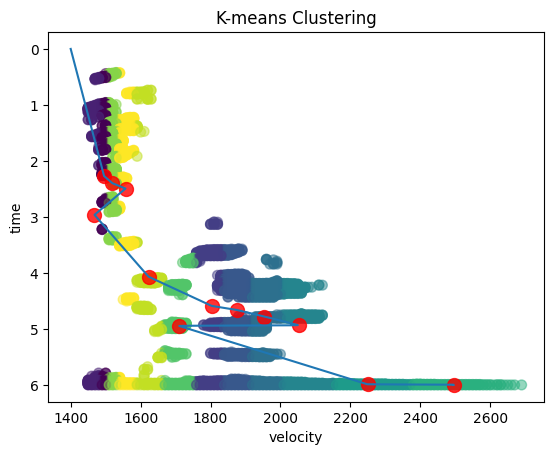

In [ ]:
plt.scatter(X[:, 1], X[:, 0], c=labels, cmap='viridis', s=50, alpha=0.5)
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=100, alpha=0.8)
plt.plot(vv, times)
plt.xlabel('velocity')
plt.ylabel('time')
plt.title('K-means Clustering')
plt.gca().invert_yaxis()
#plt.legend()
plt.show()


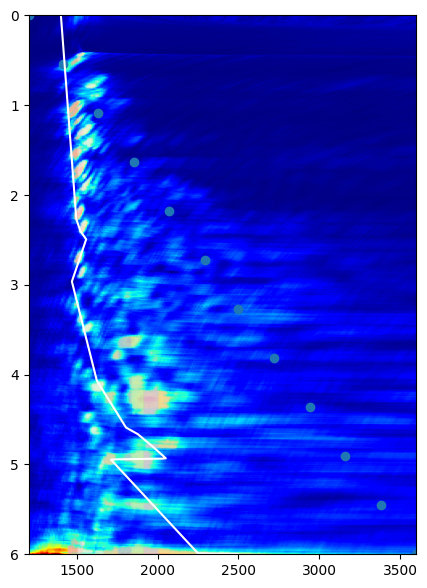

In [ ]:
plt.figure(figsize=(5,7))
plt.imshow(ss, extent=[1200, 3600, 6, 0], cmap='jet', aspect='auto', vmin=0, vmax=0.9*ss.max())
plt.scatter(X[:, 1], X[:, 0], c=labels, cmap='Pastel1', s=2, alpha=0.1)
#plt.scatter(centers[:, 1], centers[:, 0], c='red', s=100, alpha=0.8)

plt.plot(vv, times, c='1')
plt.scatter(velocity[vx], times[ty])
plt.show()

In [ ]:
vtmat1 = []
for indx in swnt_ind:
  vtmat1.append(np.array([times[indx[0]], velocity[indx[1]], ssnt[indx[0], indx[1]]]))
vtmat1 = np.asarray(vtmat1)

In [ ]:
vtmat1 = np.delete(vtmat1, idx_remove, axis=0)
vtmat1.shape

In [ ]:
vtmat1

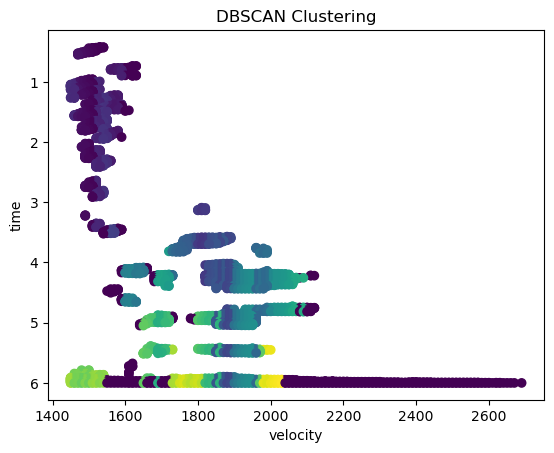

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X = vtmat
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=15, algorithm=algo[0])
y_dbscan = dbscan.fit_predict(X)

# Extract labels and core samples
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Centerss
centerss = []

# Find the center of each cluster
for i in range(n_clusters_):
    cluster_core_points = X[labels == i]
    centerss.append(np.mean(cluster_core_points, axis=0))

#print("Centers of clusters:", centers)
centerss = np.asarray(centerss)
# Plot the clustered data points
plt.scatter(X[:, 1], X[:, 0], c=y_dbscan, cmap='viridis')
#plt.scatter(centerss[:, 1], centerss[:, 0], c='red', s=200, alpha=0.8)
plt.xlabel('velocity')
plt.ylabel('time')
plt.title('DBSCAN Clustering')
plt.gca().invert_yaxis()
plt.show()


In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X = vtmat
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=15, min_samples=25, algorithm=algo[3], p =3)
y_dbscan = dbscan.fit_predict(X)

# Extract labels and core samples
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Centerss
centerss = []

# Find the center of each cluster
for i in range(n_clusters_):
    cluster_core_points = X[labels == i]
    centerss.append(np.mean(cluster_core_points, axis=0))

#print("Centers of clusters:", centers)
centerss = np.asarray(centerss)
# Plot the clustered data points
plt.scatter(X[:, 1], X[:, 0], c=y_dbscan, cmap='viridis')
#plt.scatter(centerss[:, 1], centerss[:, 0], c='red', s=200, alpha=0.8)
plt.xlabel('velocity')
plt.ylabel('time')
plt.title('DBSCAN Clustering')
plt.gca().invert_yaxis()
plt.show()


AttributeError: 'NoneType' object has no attribute 'split'

In [118]:
pip install threadpoolctl==3.1.0


  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0


In [ ]:
from sklearn.cluster import DBSCAN, hDBSCAN

In [ ]:
i = 190
plt.scatter(X[labels==i][:, 1], X[labels==i][:, 0])

In [ ]:
set(labels)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

X = vtmat

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=4, min_samples=30, algorithm='auto')
y_dbscan = dbscan.fit_predict(X)

# Extract labels and core samples
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Centers
centerss = []

# Find the center of each cluster
for i in range(n_clusters_):
    cluster_core_points = X[labels == i]
    centerss.append(np.mean(cluster_core_points, axis=0))

# Convert centerss to numpy array
centerss = np.array(centerss)

# Plot the clustered data points
plt.scatter(X[:, 1], X[:, 0], c=y_dbscan, cmap='viridis')
plt.scatter(centerss[:, 1], centerss[:, 0], c='red', s=200, alpha=0.8)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('DBSCAN Clustering')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
set(labels)